# Classification playground

Put your imports here.

In [3]:
from sklearn.ensemble import RandomForestClassifier
import pandas as pd
import numpy as np
import sqlite3
from datetime import datetime as dt

from dataset_util import uci_mhealth
from dataset_util.extract_input_features import all_feature, extract_features
import matplotlib.pyplot as plt

from config import SQLITE_DATABASE_FILE
from plots import plot_confusion_matrix

Load dataset from sqlite database.

Make sure you have downloaded the raw datasets and loaded them into the database by running:
```
python rawdataset.py
python load_dataset.py
```

In [5]:
with sqlite3.connect(SQLITE_DATABASE_FILE) as conn:
    # features = pd.read_sql_query(uci_mhealth.raw_table_valid_data_query, conn)
    global sliding_windows, subject_ids, activity_ids
    sliding_windows = uci_mhealth.to_sliding_windows(conn)
    subject_ids = uci_mhealth.get_subject_ids(conn)
    activity_ids = uci_mhealth.get_activity_ids(conn)

Now we can play with it.

features extracted
training set and test set ready
training set: (2380, 322)
test set: (1047, 322)
Confusion matrix, without normalization
[[91  0  0  0  0  0  0  0  0  0  0  0]
 [ 1 91  0  0  0  0  0  0  0  0  0  0]
 [ 0  0 93  0  0  0  0  0  0  0  0  0]
 [ 0  0  0 93  0  0  0  0  0  0  0  0]
 [ 0  0  0  3 88  0  0  1  0  0  0  0]
 [ 0  0  0  0  0 92  0  0  0  0  0  0]
 [ 0  0  0  0  0  0 94  0  1  0  0  0]
 [ 0  0  0  0  0  1  0 89  2  0  0  0]
 [ 0  0  0  0  0  0  0  0 92  0  0  0]
 [ 0  0  0  0  0  0  0  0  0 92  0  0]
 [ 0  0  0  0  0  0  0  0  0 54 37  1]
 [ 0  0  0  0  0  0  0  0  0  1  0 30]]


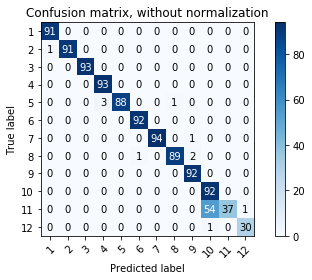

In [6]:
TRAINING_SET_PROPORTION = 0.7

features = extract_features(sliding_windows, all_feature)
print("features extracted")

n_subs = len(subject_ids)
n_training = round(n_subs * TRAINING_SET_PROPORTION)
# n_test = n_subs - n_training
idx = np.isin(features.loc[:,"subject_id"], subject_ids[:n_training])
training_set = features[idx]
test_set = features[np.logical_not(idx)]
train_X, train_y = uci_mhealth.to_classification(training_set)
test_X, test_y = uci_mhealth.to_classification(test_set)
print("training set and test set ready")
print("training set:", np.shape(train_X))
print("test set:", np.shape(test_X))

clsf = RandomForestClassifier(n_estimators=500, class_weight="balanced", n_jobs=-1)
clsf.fit(train_X,train_y)
RF_pred = clsf.predict(test_X)
# test_y = list(map(lambda x: int(x), test_y))
# RF_pred = list(map(lambda x: int(x), RF_pred))
activity_ids.sort()
activity_ids = list(map(lambda x: str(x), activity_ids))[1:]
plot_confusion_matrix(test_y, RF_pred, activity_ids)
plt.show()